In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk

from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from joblib import dump, load


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
file = 'Suicide_Ideation_Dataset(Twitter-based).csv'
df = pd.read_csv(file)

In [3]:
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [4]:
df.describe()

,Tweet,Suicide
count,1785,1787
unique,1777,2
top,AFTER EFFECTS HAS FROZEN AND I DID NOT I REPEA...,Not Suicide post
freq,2,1127


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [6]:
df.isnull().sum()

Tweet      2
Suicide    0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

Tweet      0
Suicide    0
dtype: int64

In [9]:
def plot_sns_countplot(df, column_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=column_name, palette='pastel', edgecolor=".6", order=df[column_name].value_counts().index)
    
    plt.title(f'Categorical Countplot - {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

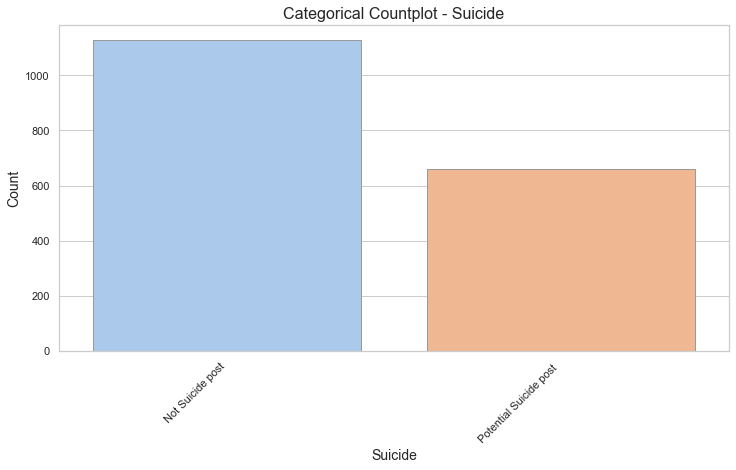

In [10]:
plot_sns_countplot(df, 'Suicide')

In [26]:
def process_text_column(df, column_name='Tweet'):
    # Define preprocessor
    def preprocessor(text):
        #removing anything after @ as its just the username
        text = re.sub(r'@[^\s]+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b(?:the|and|is|it|of|in|to|for|with|on|at|by|this|an|a)\b', ' ', text, flags=re.IGNORECASE)
        return text

    # Define tokenizer
    def tokenizer(text):
        return text.split()

    # Define lemmatizer
    def lemmatizer(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    # Define Porter Stemmer
    def porter_stemmer(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    # Define vectorizer
    def vectorizer(texts):
        tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
        X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()
        onehot_encoder = OneHotEncoder()
        X_onehot = onehot_encoder.fit_transform(X_tfidf).toarray()
        display(X_onehot)
        return X_onehot


    # Apply preprocessing
    df['Processed_Text'] = df[column_name].apply(preprocessor)

    # Tokenize
    df['Tokenized_Text'] = df['Processed_Text'].apply(tokenizer)

    # Lemmatize
    df['Lemmatized_Text'] = df['Tokenized_Text'].apply(lemmatizer)

    # Porter Stemming
    df['Stemmed_Text'] = df['Tokenized_Text'].apply(porter_stemmer)

    # Vectorize
    vectorized_documents = vectorizer(df['Processed_Text'])
    df['Vectorized_Text'] = list(vectorized_documents)

    return df

# Process the 'Tweet' column
df = process_text_column(df, column_name='Tweet')

# Display the processed DataFrame
display(df)


array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

,Tweet,Suicide,Processed_Text,Tokenized_Text,Lemmatized_Text,Stemmed_Text,Vectorized_Text,target
0,making some lunch,Not Suicide post,making some lunch,"[making, some, lunch]","[making, some, lunch]","[make, some, lunch]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
1,@Alexia You want his money.,Not Suicide post,You want his money,"[You, want, his, money]","[You, want, his, money]","[you, want, hi, money]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post,that crap took me forever put together im g...,"[that, crap, took, me, forever, put, together,...","[that, crap, took, me, forever, put, together,...","[that, crap, took, me, forev, put, togeth, im,...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post,kiwitweets Hey Jer Since when did you start t...,"[kiwitweets, Hey, Jer, Since, when, did, you, ...","[kiwitweets, Hey, Jer, Since, when, did, you, ...","[kiwitweet, hey, jer, sinc, when, did, you, st...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post,Trying out quotDelicious Library quot mixed ...,"[Trying, out, quotDelicious, Library, quot, mi...","[Trying, out, quotDelicious, Library, quot, mi...","[tri, out, quotdelici, librari, quot, mix, res...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
...,...,...,...,...,...,...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post,i have forgotten how much i love my Nokia N,"[i, have, forgotten, how, much, i, love, my, N...","[i, have, forgotten, how, much, i, love, my, N...","[i, have, forgotten, how, much, i, love, my, n...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
1783,Starting my day out with a positive attitude! ...,Not Suicide post,Starting my day out positive attitude be...,"[Starting, my, day, out, positive, attitude, b...","[Starting, my, day, out, positive, attitude, b...","[start, my, day, out, posit, attitud, be, grea...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post,Hey its amgive girl some credit trying,"[Hey, its, amgive, girl, some, credit, trying]","[Hey, it, amgive, girl, some, credit, trying]","[hey, it, amgiv, girl, some, credit, tri]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
1785,2 drunken besties stumble into my room and we ...,Not Suicide post,drunken besties stumble into my room we run...,"[drunken, besties, stumble, into, my, room, we...","[drunken, besties, stumble, into, my, room, we...","[drunken, besti, stumbl, into, my, room, we, r...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0


In [12]:
#for Suicide column lets encode and map to 0 and 1 
le = LabelEncoder()
df['target'] = le.fit_transform(df['Suicide'])


In [13]:
df.head()

,Tweet,Suicide,Processed_Text,Tokenized_Text,Lemmatized_Text,Stemmed_Text,Vectorized_Text,target
0,making some lunch,Not Suicide post,making some lunch,"[making, some, lunch]","[making, some, lunch]","[make, some, lunch]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
1,@Alexia You want his money.,Not Suicide post,You want his money,"[You, want, his, money]","[You, want, his, money]","[you, want, hi, money]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post,that crap took me forever put together im g...,"[that, crap, took, me, forever, put, together,...","[that, crap, took, me, forever, put, together,...","[that, crap, took, me, forev, put, togeth, im,...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post,kiwitweets Hey Jer Since when did you start t...,"[kiwitweets, Hey, Jer, Since, when, did, you, ...","[kiwitweets, Hey, Jer, Since, when, did, you, ...","[kiwitweet, hey, jer, sinc, when, did, you, st...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post,Trying out quotDelicious Library quot mixed ...,"[Trying, out, quotDelicious, Library, quot, mi...","[Trying, out, quotDelicious, Library, quot, mi...","[tri, out, quotdelici, librari, quot, mix, res...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0


In [14]:
X = np.vstack(df['Vectorized_Text'].to_numpy())
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size = 0.2, random_state = 0)
display(X_train)

array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

In [37]:
def rf_clf(X_train, X_test, y_train , y_test):
    # Instantiate XGBClassifier
    model =  RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    
    y_pred = model.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    cm = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate and print classification report
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)
    
    return model

In [38]:
#rf_clf(X_train, X_test, y_train, y_test)
#xgb classifier performed better

In [39]:
model = XGBClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
display(X_test.shape)
y_pred = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)
dump(model, 'xgb_clf.joblib')

(357, 21261)

Accuracy: 0.9159663865546218
Confusion Matrix:
[[210   9]
 [ 21 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       219
           1       0.93      0.85      0.89       138

    accuracy                           0.92       357
   macro avg       0.92      0.90      0.91       357
weighted avg       0.92      0.92      0.92       357



['xgb_clf.joblib']

In [40]:
new_text = "i want to die"

In [34]:
new_df = pd.DataFrame({'Tweet': [new_text]})

new_df = process_text_column(new_df, column_name='Tweet')

X = np.vstack(new_df['Vectorized_Text'].to_numpy())

array([[1., 1.]])

In [35]:
display(X.shape)

(1, 2)

In [36]:
#model = load('xgb_clf.joblib')
model.predict(X)

ValueError: Feature shape mismatch, expected: 21261, got 2